In [1]:
import sys
sys.path.append(r'..//')
from ioMicro import *

In [ ]:
\\192.168.0.3\bbfishdc10\DCBBL1_3_2_2023\MERFISH_Analysis

In [7]:
glob.glob(r'\\192.168.0.3\bbfishdc10\DCBBL1_3_2_2023\MERFISH\mosaics\*.png')

['\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\mosaics\\H9_MER_set1_col0_fr30.png',
 '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\mosaics\\H9_MER_set1_col0_fr30_annot.png',
 '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\mosaics\\H9_MER_set1_col1_fr30.png',
 '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\mosaics\\H9_MER_set1_col1_fr30_annot.png',
 '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\mosaics\\H9_MER_set1_col2_fr30.png',
 '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\mosaics\\H9_MER_set1_col2_fr30_annot.png',
 '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\mosaics\\H9_MER_set2_col0_fr30.png',
 '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\mosaics\\H9_MER_set2_col0_fr30_annot.png',
 '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\mosaics\\H9_MER_set2_col1_fr30.png',
 '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\mosaics\\H9_MER_set2_col1_fr30_annot.png',
 '\\\\192.168.0.3\\bbfishdc10\

### Pick a few calibration FOVs

Loaded decoded: -1.256880283355713


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.56it/s]


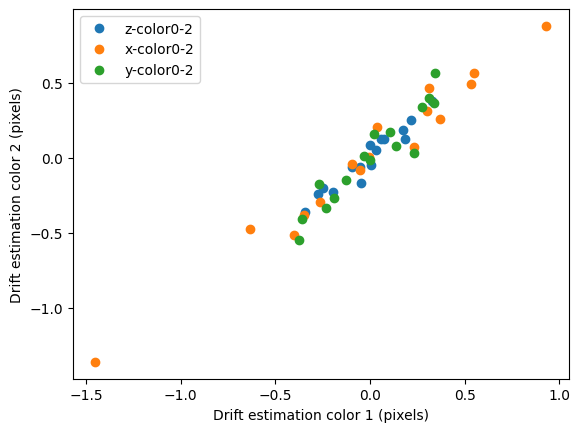

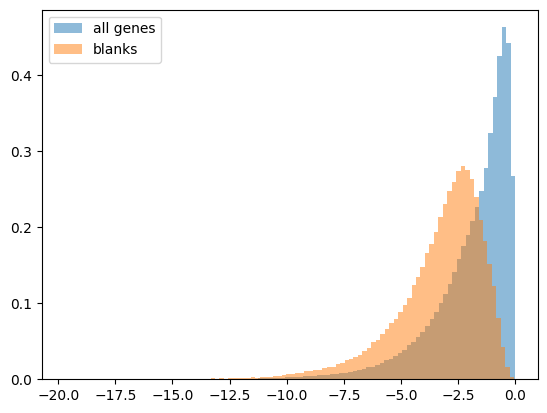

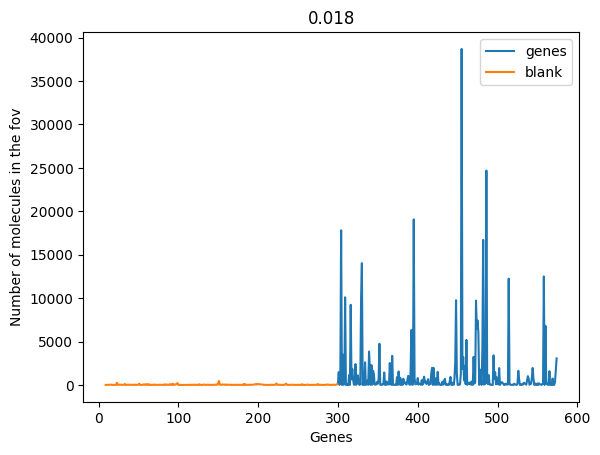

In [26]:
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
fov,set_ = 'Conv_zscan__266', '_set1'
dec = decoder_simple(save_folder,fov,set_)
dec.ncols = 3
dec.load_decoded()
apply_flat_field(dec,tag='med_col')
apply_fine_drift(dec,plt_val=True)
scoresRefT = get_score_per_color(dec)
get_score_withRef(dec,scoresRefT,plt_val=True,gene=None,iSs = None)
dec.th=-1
plot_statistics(dec)

In [27]:
viewer = plot_multigenes(dec,genes=['Sox11','Ptbp1','Gad1','Igfbpl1','Dsp','Psap'],colors=['r','g','b','m','c','y','w'],viewer = None,
                         smin=2,smax=10)

In [28]:
if True:
    if scoresRef is None: scoresRef=scoresRefT
    else: combine_scoresRef(scoresRef,scoresRefT)
    np.save(save_folder+os.sep+'scoresRef.npy',scoresRef)

C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [11]:
scoresRef = None

### Calibrate smFISH signal

In [19]:
keepf =  dec.scoreA>dec.th ### keep good score
icodesf = dec.icodesN[keepf]
XHfpr = dec.XH_pruned[keepf]
XHf = np.mean(XHfpr,axis=1)
XF = XHf[:,[0,1,2,-5,-4,-3,-2,-1,-1,-1,-1]]
#zc,xc,yc,bk-7,a-6,habs-5,hn-4,h-3
XF[:,-1] = dec.scoreA[keepf]
XF[:,-2] = np.where(keepf)[0]
mnD = np.mean(np.linalg.norm((XHf[:,np.newaxis]-XHfpr)[:,:,:3],axis=-1),axis=-1)
XF[:,-3]=mnD
mnH = np.mean(np.abs((XHf[:,np.newaxis]-XHfpr)[:,:,-3]),axis=-1)
XF[:,-4]=mnH
genesf = dec.gns_names[icodesf]

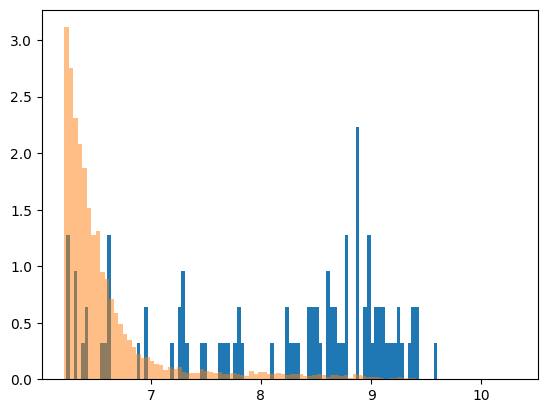

In [24]:
gene = 'Igfbpl1'
tagH = 'Ptbp1'


XF_gene = XF[genesf==gene]
icol = XF_gene[0,-5].astype(int)

dec.get_XH_tag(tag = tagH)#Aldh
#Xh = norm_brightness(dec,dec.Xh)
Xh = dec.Xh
Xh = Xh[(Xh[:,-2]==icol)&(Xh[:,-3]>500)]


dsts,inds = cKDTree(Xh[:,:3]).query(XF_gene[:,:3])
Xh_ = Xh[inds[(dsts<10)],:]
plt.hist(np.log(Xh_[:,-3]),bins=100,density=True);
plt.hist(np.log(Xh[:,-3]),bins=100,density=True,alpha=0.5);

In [25]:
np.exp(8)

2980.9579870417283

In [38]:
[2700,2000,1600]

[2700, 2000, 1600]

### Given the base decoding for each fov, run across all datasets with consistent values

In [29]:
import sys
sys.path.append(r'..\\')
from ioMicro import *
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
scoresRef = np.load(save_folder+os.sep+'scoresRef.npy',allow_pickle=True)

In [30]:
fov_fls = glob.glob(save_folder+os.sep+'fov*')
elems = [(fov.replace('.zarr',''),fov_fl.split('__')[-1].split('.')[0]) 
 for fov_fl in fov_fls for fov in np.load(fov_fl)]

In [31]:
dec_fls = glob.glob(save_folder+os.sep+"decoded*")
elems_dec = [tuple(fl.split('decoded_')[-1].replace('.npz','').split('--')) for fl in dec_fls]

In [35]:
len(elems_dec),len(elems)

(1292, 1295)

In [32]:
missing = [e for e in elems if e not in elems_dec]

In [33]:
parms = [(set_,int(fov.split('_')[-1])) for fov,set_ in missing]

In [34]:
print(parms)

[('_set1', 263), ('_set2', 99), ('_set2', 229)]


In [39]:
fov,set_ = elems[20]
dec = decoder_simple(save_folder,fov,set_)
check_image(dec)

Found files for fov: Conv_zscan__020.zarr ['\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\Controls\\H0_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\Controls\\H1_Igfbp_Aldh1l1_Ptbp1_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H1_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H2_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H3_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H4_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H5_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H6_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H7_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H8_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H9_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H10_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H11_MER_set1', '\\\\192.168.0.3\\bbfishdc10\\D

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 1499.5, 1499.5), zoom=0.3784166666666666, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(2.0, 18.0, 0.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=4, ndisplay=2, last_used=0, range=((0.0, 4.0, 1.0), (0.0, 37.0, 1.0), (0.0, 3000.0, 1.0), (0.0, 3000.0, 1.0)), current_step=(2, 18, 1500, 1500), order=(0, 1, 2, 3), axis_labels=('0', '1', '2', '3')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'im' at 0x21a0acf91c0>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ], dtype=float32), font_size=10.0

In [ ]:
from workerScope3New import *
for set_,ifov in tqdm(parms):
    main_f((set_,ifov),try_mode=True,old_method=True)

In [7]:
fov,set_ = ('Conv_zscan__029', '_set1')
save_final_decoding(save_folder,fov,set_,scoresRef,th=-1.5,plt_val=False,tag_save = 'finaldecs_',apply_flat=False,ncols=3,
                            tags_smFISH=['Aldh','Sox11'],
                            genes_smFISH=[['Igfbpl1','Aldh1l1','Ptbp1'],['Sox11','Sox2','Dcx']],Hths=[10000,10000,8500],force=False)

### Run workerSaveFinal

In [ ]:
#elems = [('Conv_zscan__'+str(ifov).zfill(3),'_'+set_)for set_ in ['set2'] for ifov in dic_f[set_]]
for fov,set_ in tqdm(elems):
    save_final_decoding(save_folder,fov,set_,scoresRef,th=-1.5,plt_val=False,tag_save = 'finaldecs_',apply_flat=False,ncols=3,
                            tags_smFISH=['Aldh','Sox11'],
                            genes_smFISH=[['Igfbpl1','Aldh1l1','Ptbp1'],['Sox11','Sox2','Dcx']],Hths=[10000,10000,8500],force=False)

In [40]:
import sys
sys.path.append(r'..\\')
from ioMicro import *
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'

In [41]:
fls = glob.glob(save_folder+os.sep+'V2_finaldecs_*')

In [43]:
times = [os.path.getctime(fl) for fl in fls]
np.mean(np.diff(np.sort(times).astype(int)))*900/60

38.231850117096016

In [42]:
len(fls)

1282

### Get counts per cell into a single dataset

In [44]:
import pandas as pd
#save_folder =r'\\192.168.0.6\bbfish1e3\DCBBL1_03_14_2023_big\MERFISH_Analysis'
#save_folder =r'\\192.168.0.6\bbfish1e3\DCBBL1_03_14_2023_big\MERFISH_Analysis'
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
save_fls = glob.glob(save_folder+os.sep+'V2_finaldecs_*')

In [47]:
len(save_fls)

1282

In [46]:
save_fls_ = [fl for fl in save_fls if (('_set1' in fl) or ('_set2' in fl))]# in fl if '035' in fl][0]
cell_df,df=None,None
for save_fl in tqdm(np.sort(save_fls_)[:]):
    ### load info
    dic = np.load(save_fl)
    XF = dic['XF']
    header = list(dic['header'])
    genes_decoded = dic['genes']
    cells = dic['cellinfo'][1:]
    header_cells = dic['header_cells']
    ### Rethrehold based on score
    iscore = list(header).index('score')
    scoreA = XF[:,iscore]
    keep = scoreA>-1.5
    ugns,gns_i = np.unique(genes_decoded[keep],return_inverse=True)

    icell = header.index('cell_id')
    icells = XF[keep,icell].astype(int)
    
    icellsf = cells[:,0].astype(int)
    
    mcell = np.max(icellsf)+1
    gn_cell,gn_cell_cts = np.unique(mcell*gns_i+icells,return_counts=True)
    len(gn_cell)
    igns_ = gn_cell//mcell
    icells_ = gn_cell%mcell
    Mcts = np.zeros([mcell,len(ugns)])
    Mcts[icells_,igns_]=gn_cell_cts

    Mcts[icellsf].shape
    ifov,iset = int(XF[0,header.index('ifov')]),int(XF[0,header.index('iset')])
    icellsnm = [icell+10**5*ifov for icell in icellsf]#icellsnm = [icell+10**5*ifov+10**9*iset for icell in icellsf]

    dfT = pd.DataFrame(Mcts[icellsf],columns=ugns,index=icellsnm)


    df = dfT if df is None else pd.concat([df,dfT])
    cell_dfT = pd.DataFrame(cells,columns=header_cells,index=icellsnm)
    cell_df = cell_dfT if cell_df is None else pd.concat([cell_df,cell_dfT])

100%|████████████████████████████████████████████████████████████████████████████████| 675/675 [05:56<00:00,  1.90it/s]


In [48]:
#save_folder = r'\\192.168.0.100\bbfish100\DCBBL1_4week_6_2_2023\MERFISH_Analysis\final_spots'
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis\final_spots'
if not os.path.exists(save_folder): os.makedirs(save_folder)
df.to_pickle(save_folder+r'\DCBBL1_3_2_2023_set1-2_df_newCellSeg.pkl')
cell_df.to_pickle(save_folder+r'\DCBBL1_3_2_2023_set1-2_cell_df_newCellSeg.pkl')

In [1]:
import sys
sys.path.append(r'..\\')
from ioMicro import *
import pandas as pd
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'

In [2]:
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis\final_spots'
df = pd.read_pickle(save_folder+r'\DCBBL1_3_2_2023_set1-2_df_newCellSeg.pkl')
cell_df = pd.read_pickle(save_folder+r'\DCBBL1_3_2_2023_set1-2_cell_df_newCellSeg.pkl')

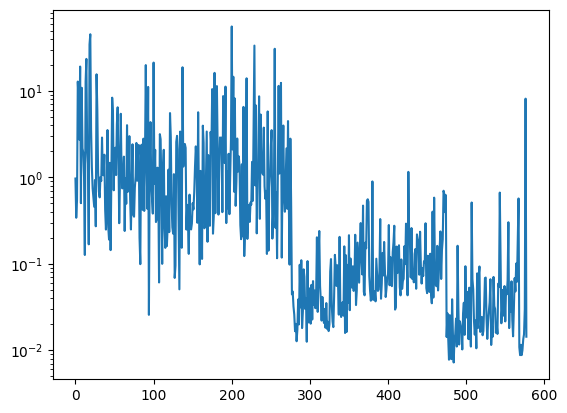

In [6]:
plt.semilogy(np.nanmean(df,axis=0))

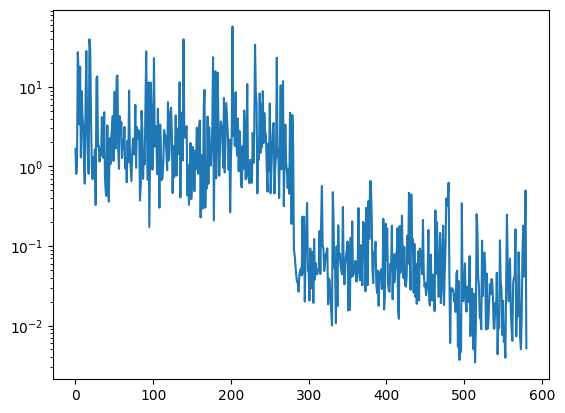

In [113]:
plt.semilogy(np.nanmean(df,axis=0))

In [16]:
          
def plot_gene_mosaic_cells(df,cell_df,gene,plt_fov=False,pixel_size = 0.10833*4,transpose=1,flipx=1,flipy=1,sz_min=1,sz_max=30,nmax=20):
    xcells = cell_df['xc']*pixel_size+cell_df['yfov']
    ycells = cell_df['yc']*pixel_size-cell_df['xfov']

    Xcells = np.array([xcells*flipx,ycells*flipy][::transpose]).T
    
    cts = np.array(df[gene])#Ptbp1_smFISH
    
    cts[np.isnan(cts)]=0
    ncts = np.clip(cts/nmax,0,1)
    size = sz_min+ncts*(sz_max-sz_min)
    from matplotlib import cm as cmap
    cols = cmap.coolwarm(ncts)
    import napari
    good_cells = slice(None)
    XC = -Xcells[good_cells,::-1]
    viewer = napari.view_points(XC,size=size,face_color=cols[good_cells],name=gene)
    if plt_fov:
        #ifovs = np.array(list(df.index),dtype=int)//10**5
        ifovs = (cell_df.index//10**5).astype(str)+'__'+cell_df['xfov'].astype(str)+'__'+cell_df['yfov'].astype(str)
        ifov_unk = np.unique(ifovs)
        Xfov = np.array([np.mean(XC[ifovs==ifov],axis=0)for ifov in ifov_unk])
        ifovs_ = np.array([int(ifov.split('_')[0])for ifov in ifov_unk])
        features =  {'fov':ifovs_}
        text = {
            'string': '{fov}',
            'size': 20,
            'color': 'gray',
            'translation': np.array([0, 0]),
        }
        viewer.add_points(Xfov,text=text,features=features,edge_width=0)

In [19]:
plot_gene_mosaic_cells(df,cell_df,'Psap',plt_fov=True,pixel_size = 0.10833*4,transpose=1)

In [57]:
list(df.keys())

['Abhd2',
 'Acer3',
 'Acta2',
 'Actb',
 'Actg1',
 'Adarb2',
 'Adcy1',
 'Adcy2',
 'Adgrl3',
 'Agt',
 'Ahcyl2',
 'Aif1l',
 'Aldh1a1',
 'Aldh1l1_smFISH',
 'Aldoc',
 'Aqp4',
 'Arx',
 'Ascl1',
 'Atp1a2',
 'Atp1b1',
 'Auts2',
 'Bcl2',
 'Bdnf',
 'Bhlhe22',
 'Bmp2',
 'Bmp4',
 'Brinp3',
 'Bsg',
 'Bsn',
 'Btg2',
 'C1qa',
 'C1ql1',
 'C1ql3',
 'Calb1',
 'Calb2',
 'Casp3',
 'Casp9',
 'Cck',
 'Cd14',
 'Cd74',
 'Cdh12',
 'Cdh13',
 'Cdh18',
 'Cdk1',
 'Cdk4',
 'Chrdl1',
 'Clasp1',
 'Cldn5',
 'Cnr1',
 'Cntnap5b',
 'Cox6a1',
 'Csmd1',
 'Cspg4',
 'Cspg5',
 'Cst3',
 'Dcc',
 'Dcx',
 'Dcx_smFISH',
 'Dgat2',
 'Dgkb',
 'Dgkh',
 'Dlx1',
 'Dlx2',
 'Dpysl3',
 'Dsp',
 'Efna5',
 'Egfem1',
 'Eif4a2',
 'Elavl2',
 'Elavl3',
 'Elavl4',
 'Emx1',
 'Emx2',
 'Eomes',
 'Erbb4',
 'Etv4',
 'F3',
 'Fam107a',
 'Fam210b',
 'Fam214a',
 'Fbll1',
 'Flt1',
 'Fos',
 'Foxa1',
 'Foxa2',
 'Foxg1',
 'Frmd4a',
 'Frzb',
 'Fxyd6',
 'Fxyd7',
 'Fyn',
 'Gabbr1',
 'Gabra1',
 'Gabra2',
 'Gad1',
 'Gal',
 'Gda',
 'Gfap',
 'Gja1',
 'Gli1',
 'Gm1007

In [109]:
import sys
sys.path.append(r'..\\')
from ioMicro import *
import pandas as pd
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'

dec = decoder_simple(save_folder,'Conv_zscan__070','_set1')

In [113]:
dec.get_XH(dec.fov,dec.set_)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:35<00:00,  2.00s/it]


In [111]:
#np.load(dec.drift_fl,allow_pickle=True)

Loaded decoded: -1.7316081523895264


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:03<00:00, 11.43it/s]


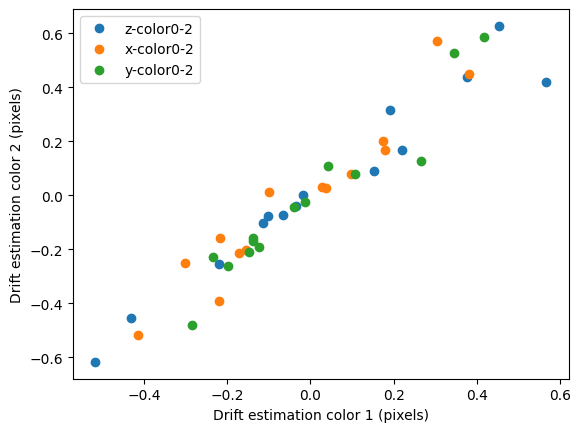

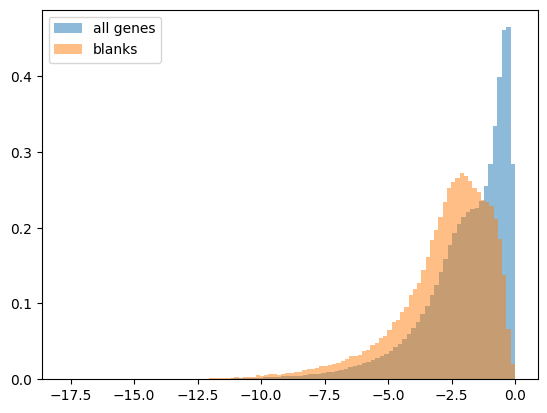

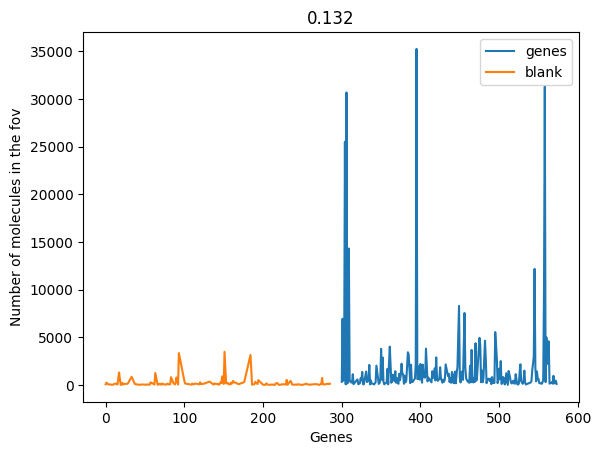

In [112]:
#save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
#fov,set_ = 'Conv_zscan__266', '_set1'
#dec = decoder_simple(save_folder,fov,set_)
dec.ncols = 3
dec.load_decoded()
apply_flat_field(dec,tag='med_col')
apply_fine_drift(dec,plt_val=True)
scoresRefT = get_score_per_color(dec)
get_score_withRef(dec,scoresRefT,plt_val=True,gene=None,iSs = None)
dec.th=-1.5
plot_statistics(dec)

In [27]:
viewer = plot_multigenes(dec,genes=['Sox11','Ptbp1','Gad1','Igfbpl1','Dsp','Psap'],colors=['r','g','b','m','c','y','w'],viewer = None,
                         smin=2,smax=10)

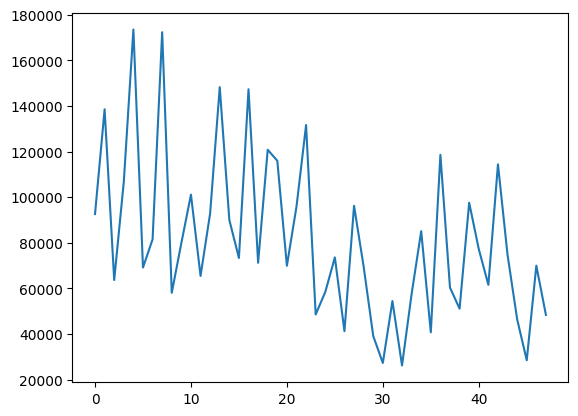

In [32]:
iRs,Rcts = np.unique(dec.XH_pruned[:,:,-1],return_counts=True)
plt.plot(iRs,Rcts)

In [ ]:
dec.get_XH(dec.fov,dec.set_,ncols=3)#number of colors match 
dec.XH = dec.XH[dec.XH[:,-4]>0.25] ### keep the spots that are correlated with the expected PSF for 60X
dec.load_library(lib_fl = r'\\192.168.0.10\bbfishdc13\codebook_0_New_DCBB-300_MERFISH_encoding_2_21_2023.csv',nblanks=-1)
dec.get_inters(dinstance_th=2,enforce_color=True)# enforce_color=False

In [45]:
dec.get_XH(dec.fov,dec.set_,ncols=3)#number of colors match 
dec.XH = dec.XH[dec.XH[:,-4]>0.25] ### keep the spots that are correlated with the expected PSF for 60X
dec.load_library(lib_fl = r'\\192.168.0.10\bbfishdc13\codebook_0_New_DCBB-300_MERFISH_encoding_2_21_2023.csv',nblanks=-1)
dec.get_inters(dinstance_th=2,enforce_color=True)# enforce_color=False
dec.get_icodes(nmin_bits=4,method = 'top4',norm_brightness=-1)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:14<00:00, 44.72s/it]


Unfolded molecules: 33.68053364753723
Computed the decoding: 28.37292170524597


100%|█████████████████████████████████████████████████████████████████████| 2488074/2488074 [00:27<00:00, 89492.61it/s]


Computed best unique assigment: 28.25812292098999


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 12.75it/s]


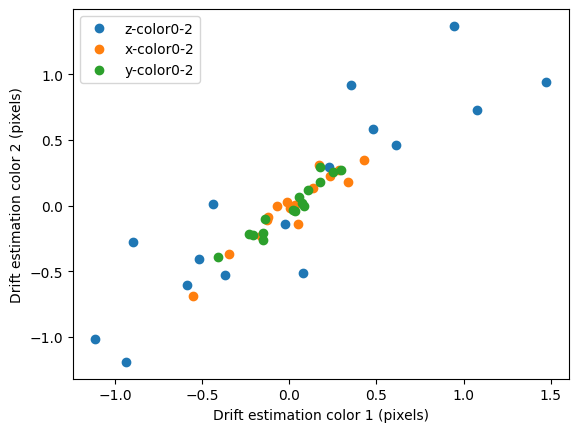

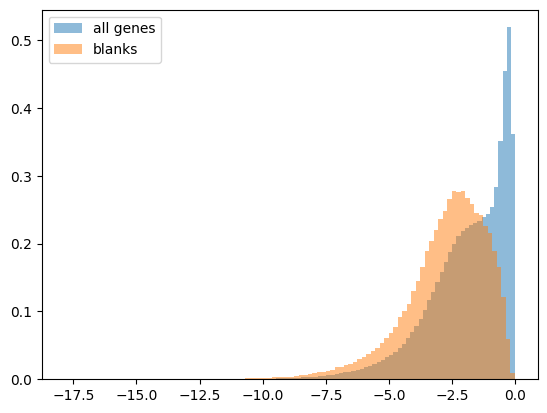

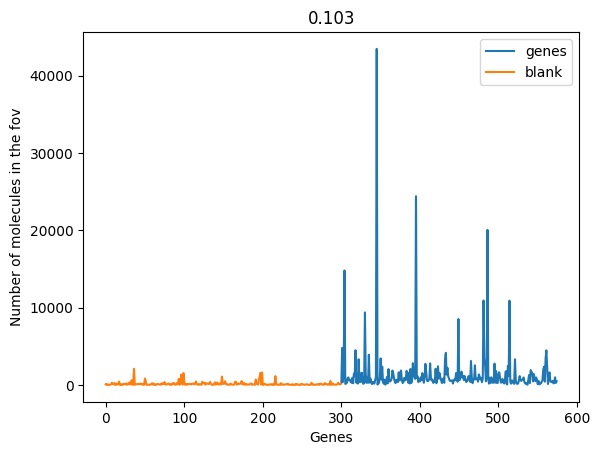

In [46]:
apply_flat_field(dec,tag='med_col')
apply_fine_drift(dec,plt_val=True)
scoresRefT = get_score_per_color(dec)
get_score_withRef(dec,scoresRefT,plt_val=True,gene=None,iSs = None)
dec.th=-1.5
plot_statistics(dec)

Loaded decoded: -1.8361892700195312


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.33it/s]


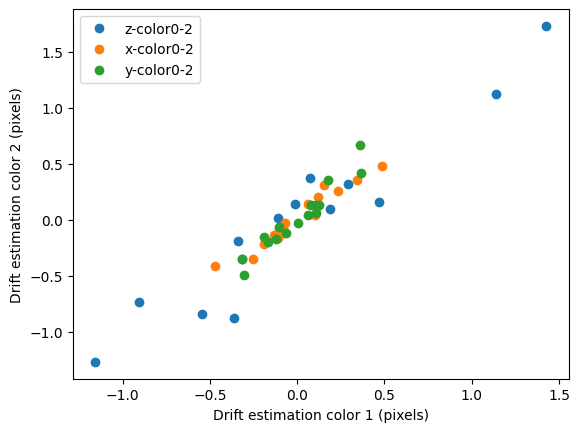

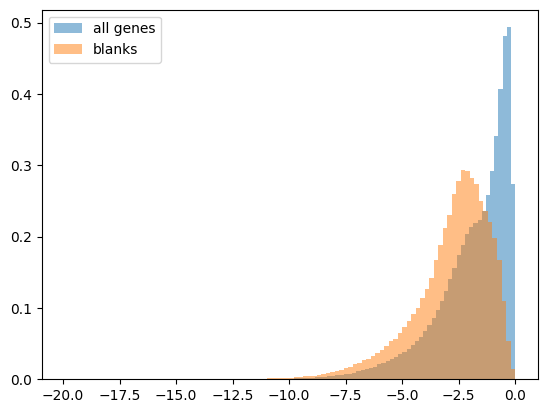

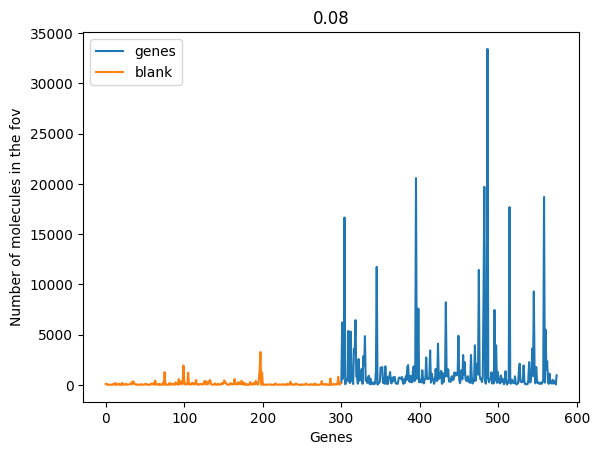

In [164]:
import sys
sys.path.append(r'..\\')
from ioMicro import *
import pandas as pd
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
dec = decoder_simple(save_folder,'Conv_zscan__183','_set2')
dec.load_decoded()
apply_flat_field(dec,tag='med_col')
apply_fine_drift(dec,plt_val=True)
scoresRefT = get_score_per_color(dec)
get_score_withRef(dec,scoresRefT,plt_val=True,gene=None,iSs = None)
dec.th=-1.5
plot_statistics(dec)

In [165]:
viewer = plot_multigenes(dec,genes=['Psap','Gad1'],colors=['r','g','b','m','c','y','w'],viewer = None,
                         smin=2,smax=10)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


Unfolded molecules: 0.8955388069152832
Computed the decoding: 0.8009796142578125


100%|███████████████████████████████████████████████████████████████████████| 100334/100334 [00:01<00:00, 90595.98it/s]


Computed best unique assigment: 1.1224944591522217


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:59<00:00, 39.85s/it]


Unfolded molecules: 39.609476804733276
Computed the decoding: 40.85438513755798


100%|█████████████████████████████████████████████████████████████████████| 4692707/4692707 [00:50<00:00, 92813.05it/s]


Computed best unique assigment: 51.415478467941284


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00,  9.90it/s]


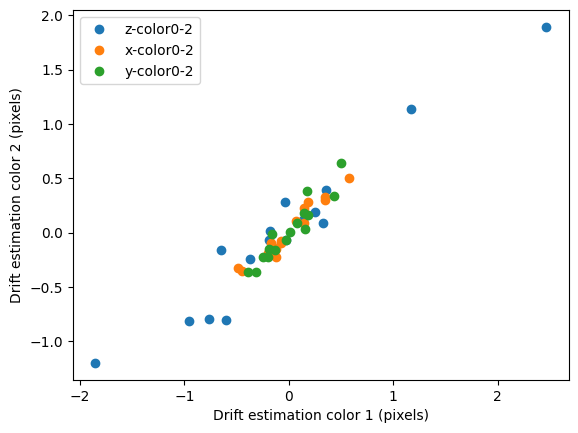

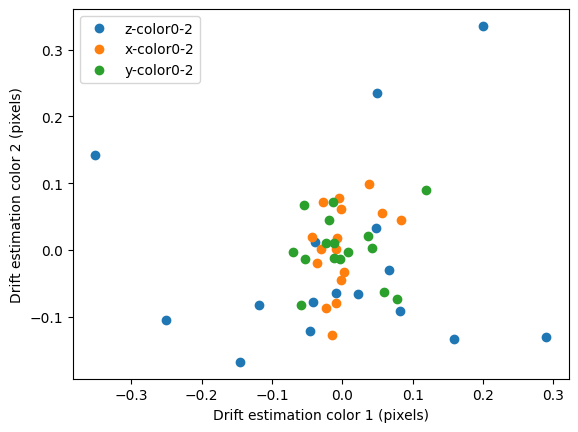

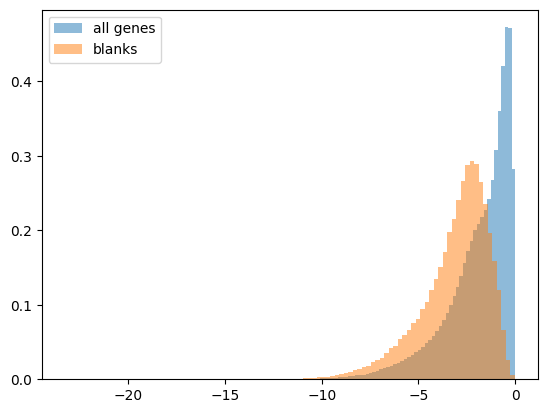

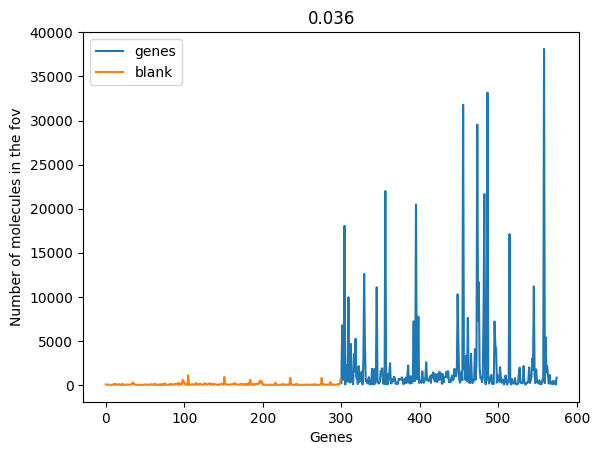

In [166]:
import sys
sys.path.append(r'..\\')
from ioMicro import *
import pandas as pd
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'

dec = decoder_simple(save_folder,'Conv_zscan__183','_set2')

dec.get_XH(dec.fov,dec.set_,ncols=3)#number of colors match 
dec.XH = dec.XH[dec.XH[:,-4]>0.25] ### keep the spots that are correlated with the expected PSF for 60X
dec.XH_save = dec.XH.copy()
#dec.XH = dec.XH[dec.XH[:,-3]>3000] ### keep the spots that are correlated with the expected PSF for 60X
dec.load_library(lib_fl = r'\\192.168.0.10\bbfishdc13\codebook_0_New_DCBB-300_MERFISH_encoding_2_21_2023.csv',nblanks=-1)
keep_best_N_for_each_Readout(dec,Nkeep = 15000)
dec.get_inters(dinstance_th=5,enforce_color=True)# enforce_color=False
dec.get_icodes(nmin_bits=4,method = 'top4',norm_brightness=-1)
apply_fine_drift(dec,plt_val=True)
dec.XH = dec.XH_save.copy()
R = dec.XH[:,-1].astype(int)
dec.XH[:,:3] -= dec.drift_arr[R]

dec.get_inters(dinstance_th=2,enforce_color=True)# enforce_color=False
dec.get_icodes(nmin_bits=4,method = 'top4',norm_brightness=-1)

apply_flat_field(dec,tag='med_col')
apply_fine_drift(dec,plt_val=True)
scoresRefT = get_score_per_color(dec)
get_score_withRef(dec,scoresRefT,plt_val=True,gene=None,iSs = None)
dec.th=-1.5
plot_statistics(dec)

In [167]:
viewer = plot_multigenes(dec,genes=['Psap','Gad1'],colors=['r','g','b','m','c','y','w'],viewer = None,
                         smin=2,smax=10)

In [43]:
check_image(dec,tag= 'dapis')

Found files for fov: Conv_zscan__053.zarr ['\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\Controls\\H0_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\Controls\\H1_Igfbp_Aldh1l1_Ptbp1_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H1_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H2_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H3_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H4_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H5_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H6_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H7_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H8_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H9_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H10_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\DCBBL1_3_2_2023\\MERFISH\\H11_MER_set2', '\\\\192.168.0.3\\bbfishdc10\\D

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 1499.5, 1499.5), zoom=0.37145, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(9.0, 2.0, 18.0, 0.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=5, ndisplay=2, last_used=0, range=((0.0, 18.0, 1.0), (0.0, 4.0, 1.0), (0.0, 37.0, 1.0), (0.0, 3000.0, 1.0), (0.0, 3000.0, 1.0)), current_step=(9, 2, 18, 1500, 1500), order=(0, 1, 2, 3, 4), axis_labels=('0', '1', '2', '3', '4')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'im' at 0x1a1953cef40>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ], dtype=f